### Task 5.1

In [ ]:
import torch
import clip
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

stl10_test = STL10(root="data", split="test", download=True, transform=preprocess)
test_loader = DataLoader(stl10_test, batch_size=64, shuffle=False)

In [20]:
labels = test_loader.dataset.classes
print(labels)

plain_text_inputs = []
for label in labels:
    plain_text_inputs.append(label)

prompt_text_inputs = []
for label in labels:
    prompt_text_inputs.append(f"a photo of a {label}")

descriptive_text_inputs = []
for label in labels:
    if label == "airplane":
        descriptive_text_inputs.append("image of an airplane soaring through the sky")
    elif label == "bird":
        descriptive_text_inputs.append("image of a bird perched on a branch")
    elif label == "car":
        descriptive_text_inputs.append("image of a car driving on a road")
    elif label == "cat":
        descriptive_text_inputs.append("image of a cat sitting on a windowsill")
    elif label == "deer":
        descriptive_text_inputs.append("image of a deer standing in a forest")
    elif label == "dog":
        descriptive_text_inputs.append("image of a dog playing in a park")
    elif label == "horse":
        descriptive_text_inputs.append("image of a horse running in a field")
    elif label == "monkey":
        descriptive_text_inputs.append("image of a monkey swinging from a tree")
    elif label == "ship":
        descriptive_text_inputs.append("image of a ship sailing on the ocean")
    elif label == "truck":
        descriptive_text_inputs.append("image of a truck parked in a lot")

['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [27]:
text_inputs = [plain_text_inputs, prompt_text_inputs, descriptive_text_inputs]
text_features_list = []
for texts in text_inputs:
    with torch.no_grad():
        text_tokens = clip.tokenize(texts).to(device)
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        text_features_list.append(text_features)

all_accuracies = []
for text_features in text_features_list:
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            logits_per_image = image_features @ text_features.t()
            preds = logits_per_image.argmax(dim=-1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    all_accuracies.append(accuracy)
    if all_accuracies.index(accuracy) == 0:
        print("Plain Text Prompt Accuracy:", accuracy)
    elif all_accuracies.index(accuracy) == 1:
        print("Prompt-based Text Accuracy:", accuracy)
    else:
        print("Descriptive Text Accuracy:", accuracy)

100%|██████████| 125/125 [00:15<00:00,  7.90it/s]


Plain Text Prompt Accuracy: 0.962375


100%|██████████| 125/125 [00:17<00:00,  7.21it/s]


Prompt-based Text Accuracy: 0.9735


100%|██████████| 125/125 [00:22<00:00,  5.63it/s]

Descriptive Text Accuracy: 0.9115


### Task 5.2

c:\Users\jibra\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


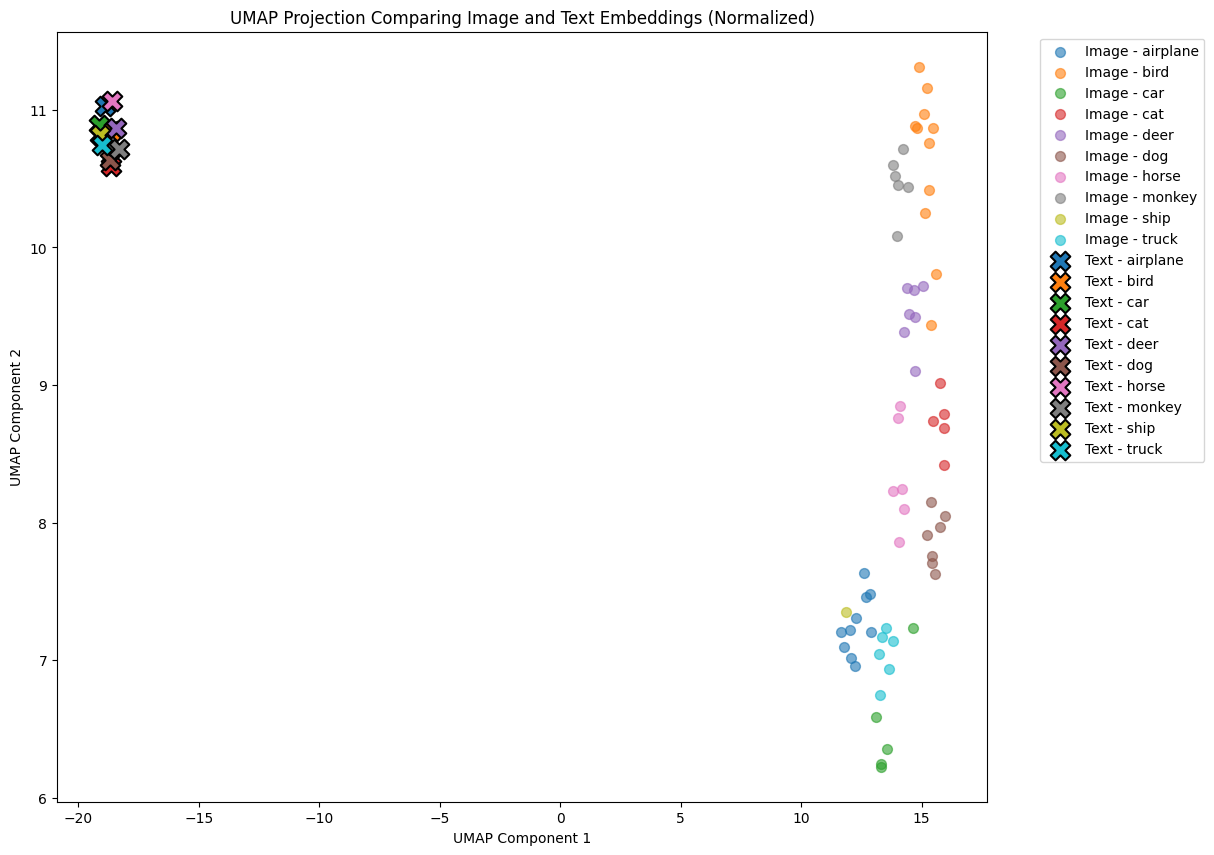

c:\Users\jibra\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


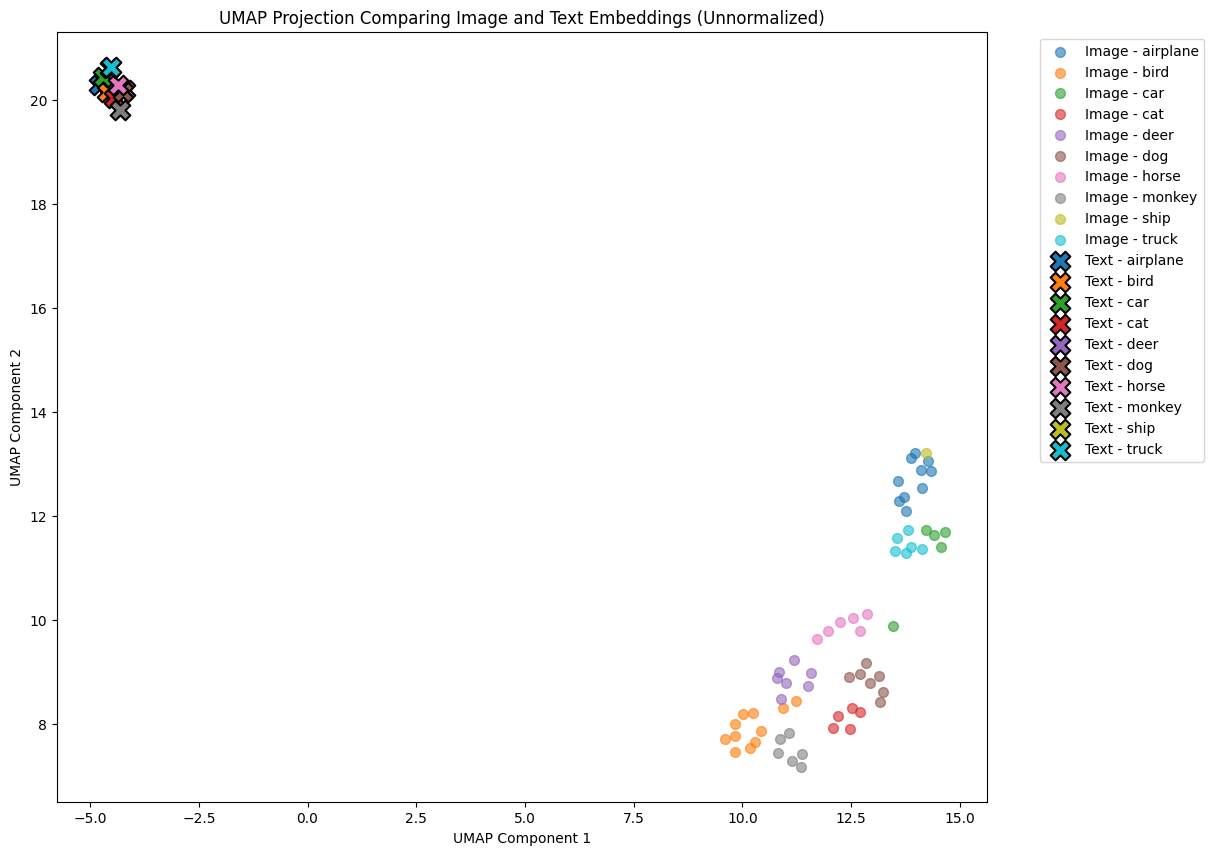

In [54]:
import torch
import clip
import numpy as np
import matplotlib.pyplot as plt
import umap

images, labels = next(iter(test_loader))
images = images.to(device)
labels_np = labels.cpu().numpy()
num_images = images.shape[0]

class_names = test_loader.dataset.classes
prompt_text_inputs = [f"a photo of a {name}" for name in class_names]

with torch.no_grad():
    image_features_unnorm = model.encode_image(images)
    text_tokens = clip.tokenize(prompt_text_inputs).to(device)
    text_features_unnorm = model.encode_text(text_tokens)

image_features_norm = image_features_unnorm / image_features_unnorm.norm(
    dim=-1, keepdim=True
)
text_features_norm = text_features_unnorm / text_features_unnorm.norm(
    dim=-1, keepdim=True
)

image_features_norm_np = image_features_norm.cpu().numpy()
text_features_norm_np = text_features_norm.cpu().numpy()

combined_features_norm = np.concatenate(
    [image_features_norm_np, text_features_norm_np], axis=0
)

image_features_unnorm_np = image_features_unnorm.cpu().numpy()
text_features_unnorm_np = text_features_unnorm.cpu().numpy()

combined_features_unnorm = np.concatenate(
    [image_features_unnorm_np, text_features_unnorm_np], axis=0
)

reducer_norm = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
combined_embedding_norm = reducer_norm.fit_transform(combined_features_norm)

img_embedding_norm = combined_embedding_norm[:num_images]
text_embedding_norm = combined_embedding_norm[num_images:]

plt.figure(figsize=(12, 10))
unique_labels = np.unique(labels_np)
for class_label in unique_labels:
    mask = labels_np == class_label
    class_name = stl10_test.classes[class_label]
    plt.scatter(
        img_embedding_norm[mask, 0],
        img_embedding_norm[mask, 1],
        label=f"Image - {class_name}",
        alpha=0.6,
        s=50,
    )

for i in range(len(text_embedding_norm)):
    class_name = stl10_test.classes[i]
    plt.scatter(
        text_embedding_norm[i, 0],
        text_embedding_norm[i, 1],
        label=f"Text - {class_name}",
        marker="X",
        s=200,
        edgecolor="black",
        linewidth=1.5,
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("UMAP Projection Comparing Image and Text Embeddings (Normalized)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

reducer_unnorm = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
combined_embedding_unnorm = reducer_unnorm.fit_transform(combined_features_unnorm)

img_embedding_unnorm = combined_embedding_unnorm[:num_images]
text_embedding_unnorm = combined_embedding_unnorm[num_images:]

plt.figure(figsize=(12, 10))
for class_label in unique_labels:
    mask = labels_np == class_label
    class_name = stl10_test.classes[class_label]
    plt.scatter(
        img_embedding_unnorm[mask, 0],
        img_embedding_unnorm[mask, 1],
        label=f"Image - {class_name}",
        alpha=0.6,
        s=50,
    )

for i in range(len(text_embedding_unnorm)):
    class_name = stl10_test.classes[i]
    plt.scatter(
        text_embedding_unnorm[i, 0],
        text_embedding_unnorm[i, 1],
        label=f"Text - {class_name}",
        marker="X",
        s=200,
        edgecolor="black",
        linewidth=1.5,
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("UMAP Projection Comparing Image and Text Embeddings (Unnormalized)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

### Task 5.3

In [ ]:
from scipy.linalg import orthogonal_procrustes

class_names = test_loader.dataset.classes
prompt_text_inputs = [f"a photo of a {name}" for name in class_names]
text_tokens = clip.tokenize(prompt_text_inputs).to(device)

with torch.no_grad():
    all_text_features = model.encode_text(text_tokens)

images, labels = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    image_features = model.encode_image(images)

corresponding_text_features = all_text_features[labels]

X_images = image_features.cpu().numpy()
Y_text = corresponding_text_features.cpu().numpy()

print(X_images.shape)
print(Y_text.shape)

R, scale = orthogonal_procrustes(X_images, Y_text)

R_tensor = torch.tensor(R, dtype=image_features.dtype).to(device)

image_features_aligned = image_features @ R_tensor

(64, 512)
(64, 512)


c:\Users\jibra\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


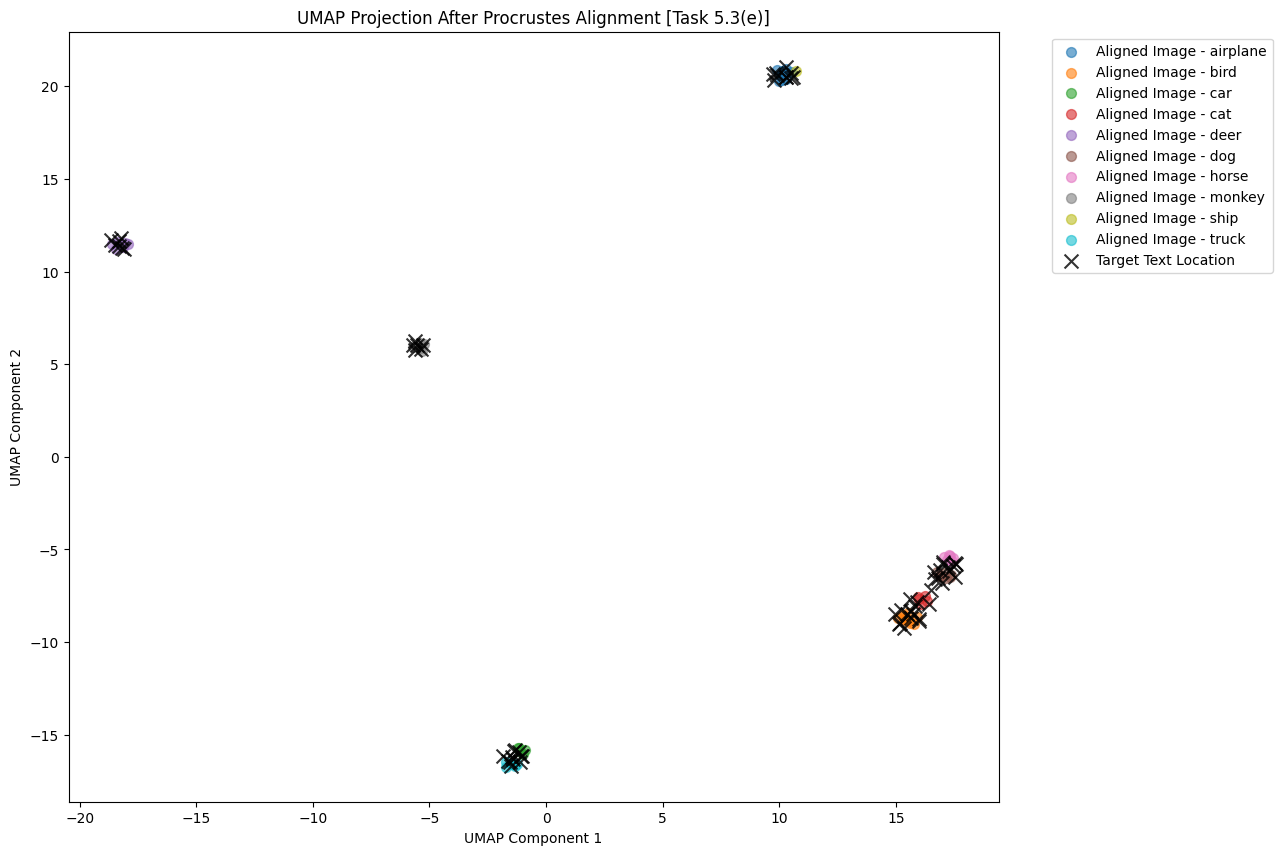

In [58]:
img_features_aligned_np = image_features_aligned.cpu().detach().numpy()
text_features_target_np = corresponding_text_features.cpu().detach().numpy()

combined_features_aligned = np.concatenate([img_features_aligned_np, text_features_target_np], axis=0)
num_images = len(img_features_aligned_np)

# --- UMAP Transformation ---
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
combined_embedding_projected = reducer.fit_transform(combined_features_aligned)

# Separate projected embeddings back into images and text components
img_embedding_projected = combined_embedding_projected[:num_images]
text_embedding_projected = combined_embedding_projected[num_images:]

# --- Plotting ---
plt.figure(figsize=(12, 10))
unique_labels = np.unique(labels_np)

# Plot image feature clusters (color-coded by class)
for class_label in unique_labels:
    mask = labels_np == class_label
    class_name = class_names[class_label] # Assuming class_names list exists
    plt.scatter(
        img_embedding_projected[mask, 0],
        img_embedding_projected[mask, 1],
        label=f"Aligned Image - {class_name}",
        alpha=0.6, s=50
    )

# Overlay corresponding text feature points
# Plot each text point individually to show where each image point *should* have landed
plt.scatter(
    text_embedding_projected[:, 0],
    text_embedding_projected[:, 1],
    label="Target Text Location",
    marker="x", c='black', s=100, alpha=0.8
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("UMAP Projection After Procrustes Alignment [Task 5.3(e)]")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

In [61]:
aligned_accs = []
for i, text_features in enumerate(text_features_list):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            image_features_original = model.encode_image(images)
            
            image_features_rotated = image_features_original @ R_tensor
            image_features_final = image_features_rotated / image_features_rotated.norm(dim=-1, keepdim=True)
            logits_per_image = image_features_final @ text_features.t()
            preds = logits_per_image.argmax(dim=-1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    aligned_accs.append(accuracy)

    if aligned_accs.index(accuracy) == 0:
        print("Plain Text Prompt Accuracy:", accuracy)
    elif aligned_accs.index(accuracy) == 1:
        print("Prompt-based Text Accuracy:", accuracy)
    else:
        print("Descriptive Text Accuracy:", accuracy)

100%|██████████| 125/125 [00:18<00:00,  6.70it/s]


Plain Text Prompt Accuracy: 0.96125


100%|██████████| 125/125 [00:19<00:00,  6.50it/s]


Prompt-based Text Accuracy: 0.951625


100%|██████████| 125/125 [00:16<00:00,  7.79it/s]

Descriptive Text Accuracy: 0.778375
